# <center>LeNet-5在MINIST数据集上的训练和测试</center>

## 1 导库、设置随机数种子、加载数据并预处理

In [79]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import time
from matplotlib import pyplot as plt
import numpy as np
import random

In [80]:
# 设置随机种子
seed = 42
torch.manual_seed(seed)
# 也设置GPU上的随机数种子
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [81]:
pipline_train = transforms.Compose([
    #随机旋转图片
    transforms.RandomHorizontalFlip(),
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    #将图片转化为Tensor格式
    transforms.ToTensor(),
    #正则化(当模型出现过拟合的情况时，用来降低模型的复杂度)
    transforms.Normalize((0.1307,),(0.3081,))    
])
pipline_test = transforms.Compose([
    #将图片尺寸resize到32x32
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])
#下载数据集
# train_set = datasets.MNIST(root="./data", train=True, download=True, transform=pipline_train)
# test_set = datasets.MNIST(root="./data", train=False, download=True, transform=pipline_test)
# 下载好了 download 就填写为 False
train_set = datasets.MNIST(root="./data", train=True, download=False, transform=pipline_train)
test_set = datasets.MNIST(root="./data", train=False, download=False, transform=pipline_test)
#加载数据集
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)

## 2 搭建 LeNet-5 神经网络结构，并定义前向传播的过程

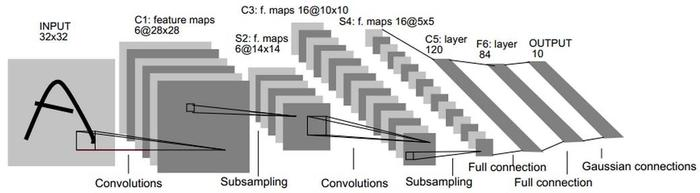

In [83]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5) 
        self.relu = nn.ReLU()
        # 最大池化
#         self.maxpool = nn.MaxPool2d(2, 2)
        # 平均池化
        self.avgpool = nn.AvgPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.avgpool(x)
        x = self.conv2(x)
        x = self.relu(x)
#         x = self.maxpool(x)
        x = self.avgpool(x)
        x = x.view(-1, 16*5*5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

## 3 将定义好的网络结构搭载到GPU，并定义优化器

In [84]:
#创建模型，部署gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LeNet().to(device)
#定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.001)
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# 学习率每隔10轮，变为原来的0.1
# scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

## 4 定义训练过程

In [85]:
def train(model, device, trainloader, optimizer, epoch):
    #训练模型, 启用 BatchNormalization 和 Dropout, 将BatchNormalization和Dropout置为True
    model.train()
    correct =0.0
    total_loss = 0.0
    iter_loss = 0.0

    #enumerate迭代已加载的数据集,同时获取数据和数据下标
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        #把模型部署到device上
        inputs, labels = inputs.to(device), labels.to(device)
        #初始化梯度
        optimizer.zero_grad()
        #保存训练结果
        outputs = model(inputs)        
        #多分类情况通常使用cross_entropy(交叉熵损失函数)
        loss = F.cross_entropy(outputs, labels)
        #计算损失和
        iter_loss += loss.item()
        total_loss += loss.item()
        #反向传播
        loss.backward()
        #更新参数
        optimizer.step()
#         scheduler.step()
        #打印每300次迭代的平均损失
        if (i+1) % 300 == 0:
            print("epoch: {}, iter: {}, lr: {}, average_loss: {:.6f}".format(epoch, i+1, optimizer.state_dict()['param_groups'][0]['lr'],iter_loss/300))
            iter_loss = 0.0
    print("epoch: {}, average_loss: {:.6f}".format(epoch, total_loss/(i+1)))
    return total_loss/(i+1)

## 5 定义测试过程

In [86]:
def test(model, device, testloader):
    #模型验证, 必须要写, 否则只要有输入数据, 即使不训练, 它也会改变权值
    #因为调用eval()将不启用 BatchNormalization 和 Dropout, BatchNormalization和Dropout置为False
    model.eval()
    #统计模型正确率, 设置初始值
    correct = 0.0
    total = 0
    #torch.no_grad将不会计算梯度, 也不会进行反向传播
    with torch.no_grad():
        for data, label in testloader:
            data, label = data.to(device), label.to(device)
            output = model(data)
            predict = output.argmax(dim=1)
            #计算正确数量
            total += label.size(0)
            correct += (predict == label).sum().item()
        #计算精度值
        print("accuracy: {:.6f}%".format(100*(correct/total)))
#     return 100*(correct/total)

## 6 训练与测试

-----------------------Start Training-----------------------

start_time 2024-05-03 00:09:34
epoch: 1, iter: 300, lr: 0.001, average_loss: 0.714301
epoch: 1, iter: 600, lr: 0.001, average_loss: 0.286678
epoch: 1, iter: 900, lr: 0.001, average_loss: 0.203379
epoch: 1, average_loss: 0.393851
end_time:  2024-05-03 00:10:08 

start_time 2024-05-03 00:10:08
epoch: 2, iter: 300, lr: 0.001, average_loss: 0.156981
epoch: 2, iter: 600, lr: 0.001, average_loss: 0.135708
epoch: 2, iter: 900, lr: 0.001, average_loss: 0.117707
epoch: 2, average_loss: 0.135787
end_time:  2024-05-03 00:10:45 

start_time 2024-05-03 00:10:45
epoch: 3, iter: 300, lr: 0.001, average_loss: 0.099807
epoch: 3, iter: 600, lr: 0.001, average_loss: 0.092553
epoch: 3, iter: 900, lr: 0.001, average_loss: 0.088114
epoch: 3, average_loss: 0.093365
end_time:  2024-05-03 00:11:18 

start_time 2024-05-03 00:11:18
epoch: 4, iter: 300, lr: 0.001, average_loss: 0.078098
epoch: 4, iter: 600, lr: 0.001, average_loss: 0.072048
epoch: 4, i

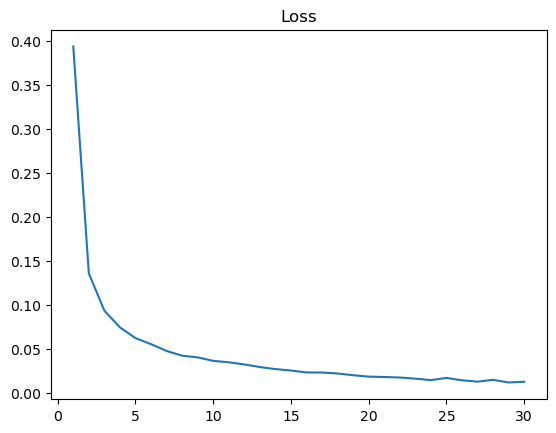

In [87]:
# 调用
epoch = 30
index = []
Loss = []
Accuracy = []
print('-----------------------Start Training-----------------------\n')
for epoch in range(1, epoch+1):
    index.append(epoch)
    print("start_time",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())))
    loss = train(model, device, trainloader, optimizer, epoch)
    Loss.append(loss)
    # 在每个epoch结束时调整学习率
#     scheduler.step()
    print("end_time: ",time.strftime('%Y-%m-%d %H:%M:%S',time.localtime(time.time())),'\n')

print('-----------------------Finish Training-----------------------\n')

print('-----------------------Start Testing-----------------------')
test(model, device, testloader)
print('-----------------------Finish Testing-----------------------\n')
plt.plot(index,Loss)
plt.title('Loss')
plt.show()


## 7 保存模型

In [89]:
print(model)
torch.save(model, './models/LeNet-5_mnist.pth') #保存模型

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (avgpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## 8 手写图片预测

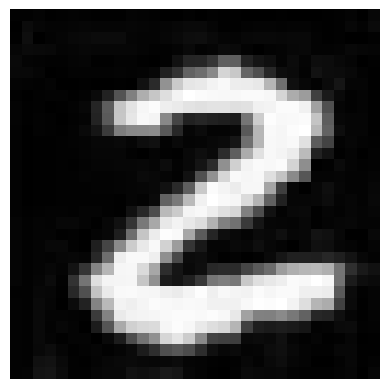

概率： tensor([[1.0907e-17, 7.6273e-10, 1.0000e+00, 1.8907e-10, 8.9585e-15, 3.5574e-10,
         8.9169e-14, 7.8419e-11, 1.2064e-17, 1.0133e-18]], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
预测类别： 2


In [94]:
import cv2

if __name__ == '__main__':
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = torch.load('./models/LeNet-5_mnist.pth') #加载模型
    model = model.to(device)
    model.eval()    #把模型转为test模式

    #读取要预测的图片
    img = cv2.imread("./data/test_mnist.jpg")
    img=cv2.resize(img,dsize=(32,32),interpolation=cv2.INTER_NEAREST)
    plt.imshow(img,cmap="gray") # 显示图片
    plt.axis('off') # 不显示坐标轴
    plt.show()

    # 导入图片，图片扩展后为[1，1，32，32]
    trans = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)#图片转为灰度图，因为mnist数据集都是灰度图
    img = trans(img)
    img = img.to(device)
    img = img.unsqueeze(0)  #图片扩展多一维,因为输入到保存的模型中是4维的[batch_size,通道,长，宽]，而普通图片只有三维，[通道,长，宽]
    
    # 预测 
    output = model(img)
    prob = F.softmax(output,dim=1) #prob是10个分类的概率
    print("概率：",prob)
    value, predicted = torch.max(output.data, 1)
    predict = output.argmax(dim=1)
    print("预测类别：",predict.item())